In [1]:
library(tidyverse)
library(here)
library(furrr)
library(cowplot)

suppressPackageStartupMessages({
library(glue)
library(lemon)
library(rtracklayer)
library(scales)
})

devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /mnt/expressions/mp/ychr
Loading required package: future

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading ychr


## Read coverage at each capture position

In [2]:
regions_cov <- function(ind, capture) {
    df <- get_coverage(here(paste0("data/coord/capture_", capture, ".bed")),
                       here(paste0("data/bam/", capture, "_", ind, ".bam"))) %>% as.data.frame
    cutoff <- quantile(df$coverage, 0.975)
    
    name <- case_when(
        ind == "den4" ~ "Denisova 4",
        ind == "den8" ~ "Denisova 8",
        ind == "spy1" ~ "Spy 1",
        ind == "mez2" ~ "Mezmaiskaya 2",
        ind == "elsidron1" ~ "El Sidrón 1253 (118 kb)",
        ind == "elsidron2" ~ "El Sidrón 1253",
        ind == "a00" ~ "A00",
        TRUE ~ ind
    )
    
    cat(glue("{ind}\n97.5% coverage quantile: {cutoff}\n\n"))
    
    select(df, start, end, coverage) %>%
        filter(coverage <= cutoff) %>%
        mutate(name = name)
}

In [3]:
den4 <- regions_cov("den4", "full")

den4
97.5% coverage quantile: 5


In [4]:
den8 <- regions_cov("den8", "full")

den8
97.5% coverage quantile: 10


In [5]:
spy1 <- regions_cov("spy1", "full")

spy1
97.5% coverage quantile: 4


In [6]:
mez2 <- regions_cov("mez2", "full")

mez2
97.5% coverage quantile: 29


In [7]:
elsidron1 <- regions_cov("elsidron1", "exome")

elsidron1
97.5% coverage quantile: 11


In [8]:
elsidron2 <- regions_cov("elsidron2", "lippold")

elsidron2
97.5% coverage quantile: 20


In [9]:
modern <-
    list.files(here("data/bam"), "full_[aS].*bam$") %>%
    str_replace_all("full_|.bam", "") %>%
    future_map_dfr(~ regions_cov(.x, "full"))

a00
97.5% coverage quantile: 35
S_BedouinB-1
97.5% coverage quantile: 32
S_Burmese-1
97.5% coverage quantile: 42
S_Dai-2
97.5% coverage quantile: 31
S_Finnish-2
97.5% coverage quantile: 26
S_French-1
97.5% coverage quantile: 33
S_Han-2
97.5% coverage quantile: 31
S_Karitiana-1
97.5% coverage quantile: 33
S_Papuan-2
97.5% coverage quantile: 34
S_Punjabi-1
97.5% coverage quantile: 27
S_Saami-2
97.5% coverage quantile: 34
S_Sardinian-1
97.5% coverage quantile: 28
S_Thai-1
97.5% coverage quantile: 37
S_Turkish-1
97.5% coverage quantile: 33


In [10]:
cov_df <- bind_rows(den4, den8, spy1, mez2, elsidron1, elsidron2, modern)

In [11]:
saveRDS(cov_df, here("data/rds/cov_df.rds"))

## Plot average coverage _per region_ along the Y chromosome

In [12]:
avg_cov <- group_by(cov_df, start, end, name) %>% summarise(avg_cov = mean(coverage))

Read some annotations and target region coordinates:

In [13]:
ychr <- read_tsv(here("input/yregions.tsv"), col_names = c("start", "end", "class"), col_types = "iic")
ychr[ychr$class == "heterochromatic", ][3, "end"] <- 29.8e6
ychr <- filter(ychr, end < 30e6)

regions <- import.bed(here("data/coord/capture_full.bed")) %>% as.data.frame %>% select(start, end)

In [14]:
plot_cov <- function(df, ind) {
    df <- filter(df, name == ind)

    ggplot() +
        geom_rect(data = df, aes(xmin = start, xmax = end, ymin = 0, ymax = avg_cov)) +
        theme_classic() +
        theme(
            legend.position = "none",
            axis.title = element_blank(),
            axis.line = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank()
        ) +
        geom_segment(aes(x = 2.4e6, xend = 29.4e6, y = c(2, 10, 20), yend = c(2, 10, 20)), linetype = 2, size = 0.1) +
        geom_segment(aes(x = 2.4e6, xend = 29.4e6, y = 0, yend = 0), size = 0.1) +
        geom_text(aes(2.2e6, 8, label = ind), hjust = "right") +
        xlim(x = c(0, 30e6)) + ylim(0, 25) +
        geom_text(aes(29.5e6, c(3, 11, 21), label = c("2X", "10X", "20X")), size = 3, hjust = "left")
}

In [15]:
p_den4 <- plot_cov(avg_cov, "Denisova 4")
p_den8 <- plot_cov(avg_cov, "Denisova 8")
p_spy1 <- plot_cov(avg_cov, "Spy 1")
p_mez2 <- plot_cov(avg_cov, "Mezmaiskaya 2")
p_elsidron <- plot_cov(avg_cov, "El Sidrón 1253")

p_regions <- ggplot(regions) +
    geom_rect(aes(xmin = start, xmax = end, ymin = 0, ymax = 1)) +
    theme_classic() +
    theme(
        legend.position = "none",
        axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()
    ) +
    xlim(x = c(0, 30e6)) + ggtitle("   ")

p_ychr <- ychr %>% mutate(class = fct_relevel(class, "others", after = Inf)) %>%
    ggplot() +
    geom_rect(aes(xmin = start, xmax = end, ymin = 0.2, ymax = 1, fill = class)) +
    theme_classic() +
    theme(
        legend.position = "bottom",
        axis.title = element_blank(),
        axis.line.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    ) +
    geom_segment(aes(y = 0.2, yend = 1, x = 40e3, xend = 40e3), size = 1/2) +
    geom_segment(aes(y = 0.2, yend = 0.2, x = 0, xend = 30e6), size = 1/2) +
    geom_segment(aes(y = 1, yend = 1, x = 0, xend = 30e6), size = 1/2) +
    ylim(0, 1) +
    scale_x_continuous(limits = c(0, 30e6), label = comma) +
    scale_fill_manual(name = "", values = c("#E69F00", "lightgray", "#CC79A7", "#0072B2", "#D55E00", "#009E73")) +
    coord_capped_cart(bottom = "both")

## Figure 1

Warning message:
“Removed 3 rows containing missing values (geom_rect).”Warning message:
“Removed 3 rows containing missing values (geom_rect).”Warning message:
“Removed 3 rows containing missing values (geom_rect).”Warning message:
“Removed 3 rows containing missing values (geom_rect).”Warning message:
“Removed 3 rows containing missing values (geom_rect).”

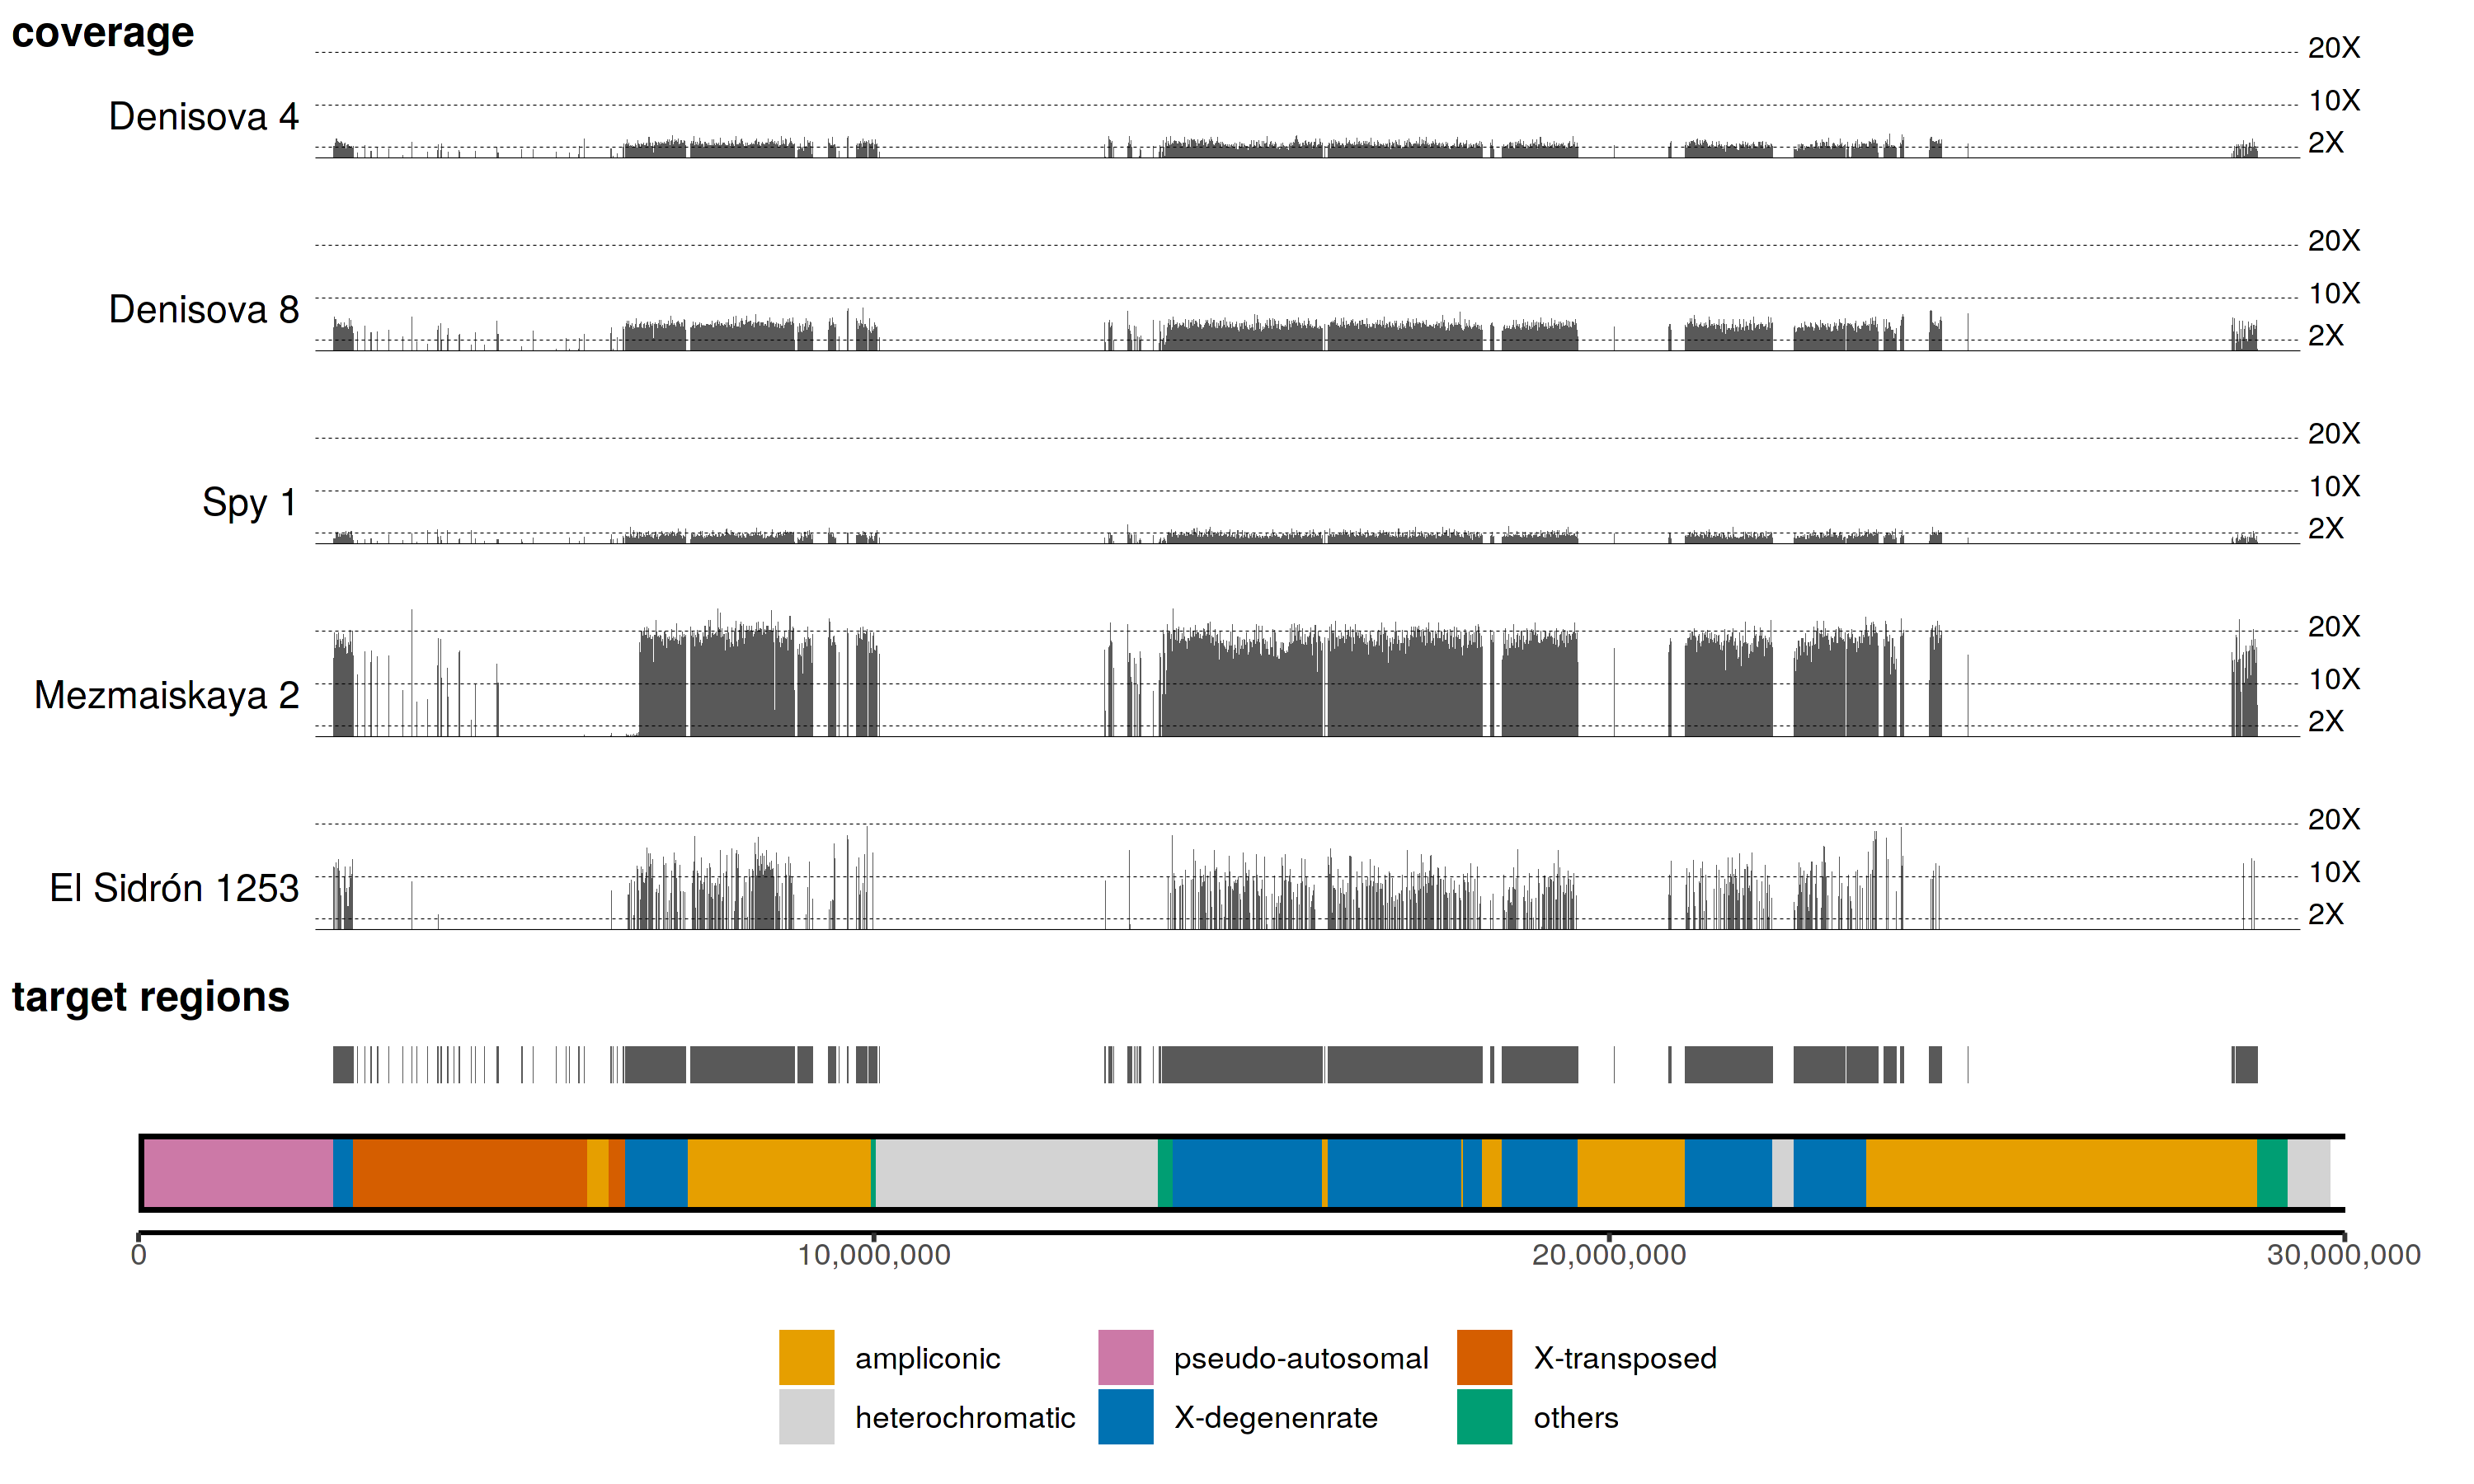

In [16]:
set_dim(10, 6)

plot_grid(p_den4, p_den8, p_spy1, p_mez2, p_elsidron, p_regions, p_ychr, ncol = 1,
          labels = c(" coverage", "", "", "", "", " target regions", ""), hjust = "left", label_size = 12,
          rel_heights = c(0.13, 0.13, 0.13, 0.13, 0.13, 0.1, 0.25))

ggsave(here("figures/coverage_spatial.png"), width = 10, height = 6)

## Coverage statistics

In [17]:
archaic_df <- filter(cov_df, name %in% c("Spy 1", "Mezmaiskaya 2", "Denisova 4", "Denisova 8", "El Sidrón 1253", "El Sidrón 1253 (118 kb)"))
modern_df <- filter(cov_df, !name %in% c("Spy 1", "Mezmaiskaya 2", "Denisova 4", "Denisova 8", "El Sidrón 1253"))

In [18]:
archaic_df %>%
    group_by(name) %>%
    summarise(avg_cov = mean(coverage)) %>%
    arrange(avg_cov)

modern_df %>%
    group_by(name) %>%
    summarise(avg_cov = mean(coverage)) %>%
    arrange(avg_cov)

name,avg_cov
<chr>,<dbl>
Spy 1,0.8253635
Denisova 4,1.5451500
El Sidrón 1253 (118 kb),3.1318824
Denisova 8,3.4819494
El Sidrón 1253,7.8449213
Mezmaiskaya 2,14.2548400


name,avg_cov
<chr>,<dbl>
El Sidrón 1253 (118 kb),3.131882
S_Finnish-2,16.927911
S_Punjabi-1,17.147003
S_Sardinian-1,18.036396
S_Dai-2,19.811971
S_Han-2,20.680072
A00,20.867157
S_BedouinB-1,21.618394
S_French-1,21.903125


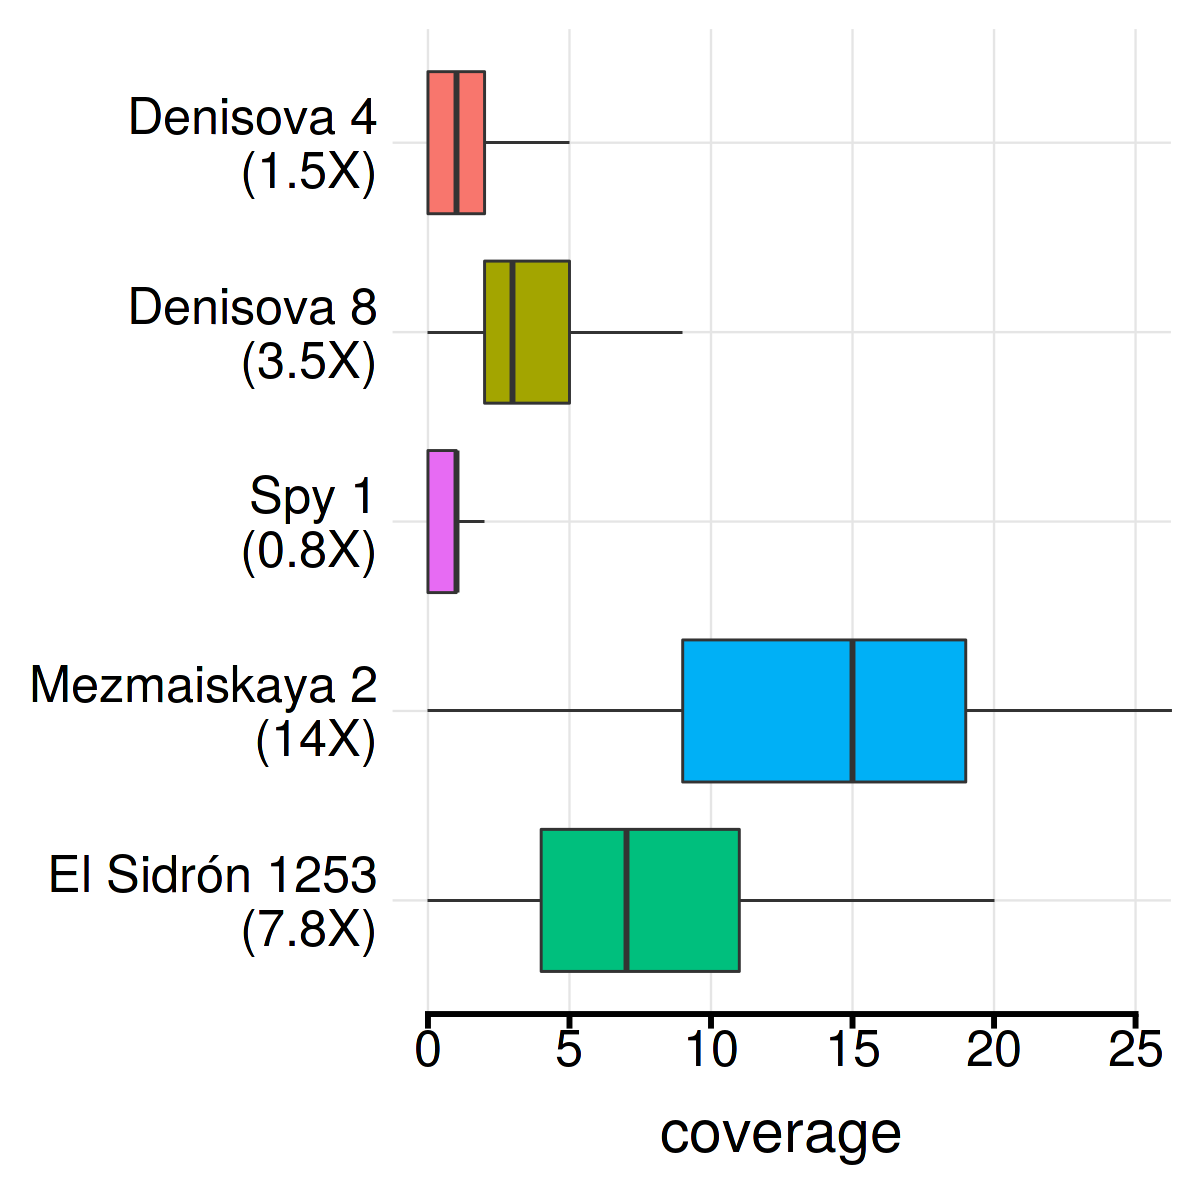

In [19]:
set_dim(4, 4)

archaic_df %>%
    filter(name != "El Sidrón 1253 (118 kb)") %>%
    mutate(name = case_when(name == "Denisova 4" ~ "Denisova 4\n(1.5X)",
                            name == "Denisova 8" ~ "Denisova 8\n(3.5X)",
                            name == "El Sidrón 1253" ~ "El Sidrón 1253\n(7.8X)",
                            name == "Mezmaiskaya 2" ~ "Mezmaiskaya 2\n(14X)",
                            name == "Spy 1" ~ "Spy 1\n(0.8X)")) %>%
ggplot(aes(fct_relevel(name, c("El Sidrón 1253\n(7.8X)", "Mezmaiskaya 2\n(14X)", "Spy 1\n(0.8X)",
                               "Denisova 8\n(3.5X)", "Denisova 4\n(1.5X)")),
       coverage, fill = name)) +
    geom_boxplot(size = 0.25, outlier.shape = NA) +
    theme(
        legend.position = "none",
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank()
    ) +
    background_grid(major = "xy", minor = "none") +
    coord_capped_flip(ylim = c(0, 25), bottom = "both", left = "none")

ggsave(here("figures/coverage_boxplots.png"), width = 4, height = 4)